# **Pantanal.dev**

### Análise de Sentimentos (Tweets)

Este projeto tem por objetivo desenvolver um modelo de análise de sentimentos utilizando tweets com o uso do modelo pré-treinado BERT. 



### Setup

Instala bibliotecas necessárias

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.9 MB/s eta 0:00:00


Importa bibliotecas necessárias

In [57]:
import torch
import re
import transformers

import torch.nn as nn
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from google.colab import drive
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

Declara variáveis globais

In [49]:
BATCH_SIZE = 32
MAX_LENGTH = 150
RANDOM_SEED = 56
NUM_CLASSES = 3
EPOCHS = 10
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Inicialização

Carrega base de dados do Drive

In [4]:
drive.mount("/content/drive")

url = "/content/drive/MyDrive/tweets_large.csv"

tweets = pd.read_csv(url)

Mounted at /content/drive


Mostra base de dados

In [5]:
tweets

,tweet_text,sentiment
0,@Tixaa23 14 para eu ir :),Positivo
1,@drexalvarez O meu like eu já dei na época :),Positivo
2,Eu só queria conseguir comer alguma coisa pra ...,Positivo
3,:D que lindo dia !,Positivo
4,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Positivo
...,...,...
2995,@Leidetransito Vai perder seu tempo! #Fato rs,Neutro
2996,É #FATO que vale manter aspirina à mão em caso...,Neutro
2997,"#FATO!!! ESPERAR NO SENHOR É BOM, PERFEITO E A...",Neutro
2998,frio não é castigo nenhum pra quem ta solteiro...,Neutro


Imprime quantidade de tweets positivos, negativos e neutros

In [6]:
tweets['sentiment'].value_counts()

Positivo    1000
Negativo    1000
Neutro      1000
Name: sentiment, dtype: int64

### Limpeza de dados

Realiza limpeza nos tweets

In [7]:
def clean_tweet(tweet):
  # Converte tudo para minúsculo
  tweet = tweet.lower()

  # Remove menções
  tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)

  # Remove #
  tweet = re.sub(r'#', '', tweet)

  # Remove hyperlinks
  tweet = re.sub(r'https?:\/\/\S+', '', tweet)

  # Remove pontuação
  tweet = re.sub(r'[^\w\s]', '', tweet)

  return tweet

In [8]:
def limpa_tweets(tweets):
  # Percorre lista de tweets e realiza a limpeza
  for i in range(len(tweets['tweet_text'])):
    tweets['tweet_text'][i] = clean_tweet(tweets['tweet_text'][i])

In [9]:
limpa_tweets(tweets)

Converte cada classe de sentimento em um ID

2 : Positivo

1 : Neutro

0 : Negativo

In [10]:
def formata_sentimentos(tweets):
  for i in range(len(tweets.sentiment)):
    if tweets.sentiment[i] == 'Positivo':
      tweets.sentiment[i] = 2
    elif tweets.sentiment[i] == 'Neutro':
      tweets.sentiment[i] = 1
    elif tweets.sentiment[i] == 'Negativo':
      tweets.sentiment[i] = 0

In [11]:
formata_sentimentos(tweets)

Contabiliza quantidade máxima de tokens em um tweet (utilizado para definir a variável global MAX_LENGTH)

In [15]:
token_lengths = []

for tweet in tweets.tweet_text:
  token = tokenizer.encode(tweet, truncation = True, max_length = 512)
  token_lengths.append(len(token))

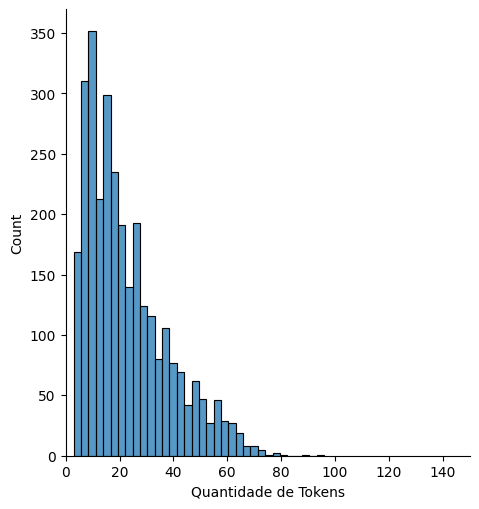

In [16]:
sns.displot(token_lengths)

plt.xlim([0, 150]);
plt.xlabel('Quantidade de Tokens');

### Divisão de Datasets

Divide base de dados original em uma base de treino (70%), teste (20%) e validação (10%) e com quantidade proporcionais de cada sentimento

In [29]:
dataset_train, dataset_test = train_test_split(tweets, test_size = 0.3, random_state = RANDOM_SEED, shuffle = True, stratify = tweets.sentiment)
dataset_test, dataset_val = train_test_split(dataset_test, test_size = 0.66, random_state = RANDOM_SEED, shuffle = True, stratify = dataset_test.sentiment)

Mostra quantidade de tweets de cada sentimento em cada dataset

In [30]:
print("Train")
print(dataset_train.sentiment.value_counts())
print()
print("Val")
print(dataset_val.sentiment.value_counts())
print()
print("Test")
print(dataset_test.sentiment.value_counts())

Train
1    700
2    700
0    700
Name: sentiment, dtype: int64

Val
1    198
2    198
0    198
Name: sentiment, dtype: int64

Test
2    102
0    102
1    102
Name: sentiment, dtype: int64


### DataLoader

Cria classe TweetDataset para representar um conjunto de dados contendo tweets

In [31]:
class TweetDataset(Dataset):
  def __init__(self, tweets, sentiments, tokenizer):
    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = MAX_LENGTH

  def __getitem__(self, index):
    tweet = self.tweets[index]
    sentiment = self.sentiments[index]

    token = tokenizer(
      tweet,
      max_length = self.max_len,
      add_special_tokens = True,
      return_token_type_ids = False,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt',
    )

    return {
        'tweet_text' : tweet,
        'input_ids': token['input_ids'].flatten(),
        'attention_mask': token['attention_mask'].flatten(),
        'sentiment': torch.tensor(sentiment, dtype=torch.long)
    }
 
  def __len__(self):
    return len(self.tweets)

Cria função responsável por retornar os *dataloader* com seus respectivos *batches*

In [32]:
def create_dataloader(tweets, tokenizer):
  dataset = TweetDataset(
      tweets.tweet_text.to_numpy(),
      tweets.sentiment.to_numpy(),
      tokenizer
  )

  return DataLoader(
      dataset,
      batch_size = BATCH_SIZE
  )

Cria *dataloaders* de treino, validação e teste

In [41]:
train_dataloader = create_dataloader(dataset_train, tokenizer)
test_dataloader = create_dataloader(dataset_test, tokenizer)
val_dataloader = create_dataloader(dataset_val, tokenizer)

### Modelo

Cria classe para representar o modelo

In [42]:
class TweetClassifier(nn.Module):
  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p = 0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, NUM_CLASSES)

  def forward(self, input_ids, attention_mask):
    # Coloca entrada no modelo BERT
    _, output = self.bert(input_ids, attention_mask, return_dict = False)

    # Coloca saída do BERT na entrada da Dropout
    output = self.drop(output)

    # Retorna a saída da camada Linear usando a saída da Dropout como entrada
    return self.out(output)

Instancia a classe com o modelo a ser utilizado e define o *optimizer*, *scheduler* e função de loss a serem utilizados

In [43]:
model = TweetClassifier()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps = 0,
  num_training_steps = total_steps
)

loss_function = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Encapsula função responsável por rodar uma epoch de treino

In [44]:
def train_epoch(model, dataloader, loss_function, optimizer, scheduler, len_dataset):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for batch in dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    sentiments = batch['sentiment'].to(device)

    outputs = model(input_ids, attention_mask)

    _, preds = torch.max(outputs, dim = 1)

    loss = loss_function(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / len_dataset, np.mean(losses)

Encapsula função responsável por rodar uma epoch de validação

In [45]:
def evaluation(model, dataloader, loss_function, len_dataset):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for batch in dataloader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      sentiments = batch["sentiment"].to(device)

      outputs = model(input_ids, attention_mask)

      _, preds = torch.max(outputs, dim = 1)

      loss = loss_function(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return correct_predictions.double() / len_dataset, np.mean(losses)

### Treino

In [50]:
train_accuracy_list = []
train_loss_list = []

val_accuracy_list = []
val_loss_list = []

best_accuracy = 0

for epoch in range(EPOCHS):
  print("Epoch %d/%d" % (epoch + 1, EPOCHS))
  print("-" * 54)

  train_accuracy, train_loss = train_epoch(
    model,
    train_dataloader,    
    loss_function, 
    optimizer, 
    scheduler, 
    len(dataset_train)
  )

  print("Loss (Train)     : %.8f --> Accuracy: %.8f" % (train_loss, train_accuracy))

  val_accuracy, val_loss = evaluation(
    model,
    val_dataloader,
    loss_function,
    len(dataset_val)
  )

  print("Loss (Validation): %.8f --> Accuracy: %.8f" % (val_loss, val_accuracy))
  print()

  train_accuracy_list.append(train_accuracy)
  train_loss_list.append(train_loss)
  val_accuracy_list.append(val_accuracy)
  val_loss_list.append(val_loss)

  if val_accuracy > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_accuracy

Epoch 1/10
------------------------------------------------------
Loss (Train)     : 0.17324199 --> Accuracy: 0.94142857
Loss (Validation): 0.46521106 --> Accuracy: 0.86026936

Epoch 2/10
------------------------------------------------------
Loss (Train)     : 0.09441413 --> Accuracy: 0.96904762
Loss (Validation): 0.57998460 --> Accuracy: 0.84343434

Epoch 3/10
------------------------------------------------------
Loss (Train)     : 0.04014011 --> Accuracy: 0.99000000
Loss (Validation): 0.66983987 --> Accuracy: 0.85858586

Epoch 4/10
------------------------------------------------------
Loss (Train)     : 0.02451611 --> Accuracy: 0.99476190
Loss (Validation): 0.76748988 --> Accuracy: 0.84848485

Epoch 5/10
------------------------------------------------------
Loss (Train)     : 0.01864108 --> Accuracy: 0.99666667
Loss (Validation): 0.72420388 --> Accuracy: 0.86026936

Epoch 6/10
------------------------------------------------------
Loss (Train)     : 0.01443759 --> Accuracy: 0.997

### Acurácia

Avaliação da acurácia ao longo das épocas

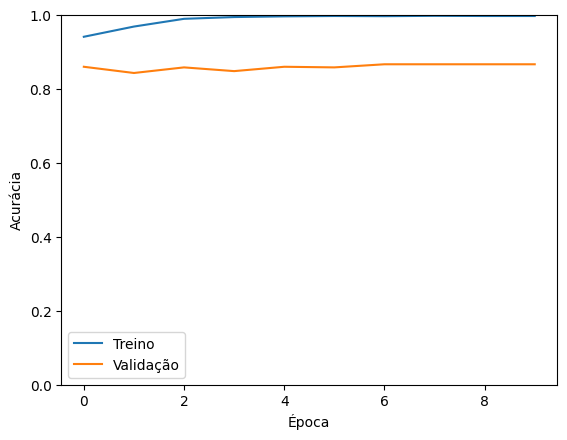

In [51]:
train_acc_list = [acc.cpu().numpy() for acc in train_accuracy_list]
val_acc_list = [acc.cpu().numpy() for acc in val_accuracy_list]

plt.ylim([0, 1]);
plt.plot(train_acc_list, label = "Treino")
plt.plot(val_acc_list, label = "Validação")
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()
plt.show()

### Loss

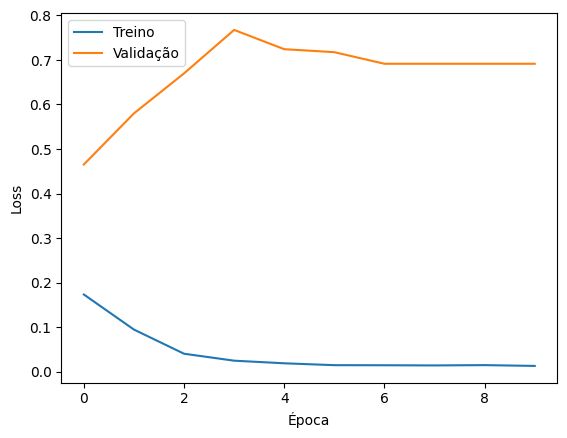

In [52]:
plt.plot(train_loss_list, label = "Treino")
plt.plot(val_loss_list, label = "Validação")
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()
plt.show()

### Teste

In [2]:
# dataset_test

# Pos, Neg, Neu
tests = ["hoje o dia foi horrivel", 

        "que dia feliz",
         
         "nada pra fazer"
         ]

In [3]:
for test in tests:
  encoded_tweet = tokenizer.encode_plus(
    test,
    max_length = MAX_LENGTH,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding = 'max_length',
    return_attention_mask = True,
    return_tensors='pt',
  )

  input_ids = encoded_tweet['input_ids'].to(device)
  attention_mask = encoded_tweet['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  probs = F.softmax(output, dim=1)

  print(f'Tweet: {test}')
  print(pd.DataFrame(probs.tolist()[0], ['positivo', 'negativo', 'neutro'])[0])
  print("========================\n")

NameError: ignored